##Trabajo Practico Aprendizaje Automatico 1: Predicción de lluvia en Australia.


Dataset y objetivos:

El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas **‘RainTomorrow’** y **‘RainfallTomorrow’**. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.


Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

# Librerias a usar

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import RandomOverSampler, SMOTE

#1. Limpieza del Dataset

##Carga del dataset

In [ ]:
df=pd.read_csv("/content/weatherAUS.csv", encoding="UTF-8")
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


Dado que la primer columna es el indice la eliminamos

In [ ]:
df=df.iloc[:, 1:]
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


filtramos solamentes para las ciudades de nuestro interes

In [ ]:
ciudades=["Melbourne","MelbourneAirport","Canberra","Sydney","SydneyAirport"]

df=df.query("Location.isin(@ciudades)")

df.shape

(15986, 24)

Revisamos si existen valores faltantes

In [ ]:
df.isna().sum()

Date                   0
Location               0
MinTemp              491
MaxTemp              486
Rainfall             787
Evaporation         1706
Sunshine            1948
WindGustDir         1457
WindGustSpeed       1455
WindDir9am           695
WindDir3pm           290
WindSpeed9am         261
WindSpeed3pm         249
Humidity9am          570
Humidity3pm          525
Pressure9am          735
Pressure3pm          726
Cloud9am            2677
Cloud3pm            2932
Temp9am              505
Temp3pm              496
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
dtype: int64

## Tratamiento de datos faltantes

In [ ]:
def fill_missing_values(column):
    column.interpolate(method='linear',inplace=True, limit_direction='both')
    return column


Para los siguientes valores vamos a utilizar el metodo de interpolacion. Este metodo lo que realiza es rellenar el valor faltante con el promedio entre el anterior y el siguiente.

Esta tecnica de rellenado de datos faltantes es util para aquellos datos que son lineales. Entendiendo la temperatura, la humedad, y la presión como lineal, si vemos una serie temporal de temperatura, podemos ver que los cambios no son tan bruscos entre dias pero si son mas bruscos entre meses. Por lo cual la interpolacion nos parece la mejor manera de rellenar los datos faltantes. Claramente esto es una aproximacion

In [ ]:
columnas_interpolate=[df["MinTemp"],df["MaxTemp"],df["Evaporation"],df["Sunshine"],df['Humidity9am'],df['Humidity3pm'],df['Pressure9am'],df['Pressure3pm'],df['Temp9am'],df["Temp3pm"]]

In [ ]:
for col in columnas_interpolate:
  fill_missing_values(col)

En la columna WindGustDir, casi los primeros 1000 registros estan vacios. Lo que proponemos hacer es llenar estos mil registros con o la copia de estos datos pero de otro año o, intentado inventar una regla de 3 entre temperatura maxima y direccion del viento (a debatir)

OOO LA QUE PODEMOS SACAR ES RELLENARLOS CON UN PROMEDIO ENTRE WINDDIR9AM Y WINDDIR3PM

No parece de gran ayuda al modelo del problema poder entender el mes y la estacion del año. Ya que esto es fundamental a la hora de comprender el comportamiento de las variables climaticas

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df['Month'] = df["Date"].dt.month


In [ ]:
 df['Season'] = df["Month"].map({1: 'Summer', 2: 'Summer', 3: 'Autumn', 4: 'Autumn', 5: 'Autumn', 6: 'Winter', 7: 'Winter', 8: 'Winter', 9: 'Spring', 10: 'Spring', 11: 'Spring', 12: 'Summer'})

Mediante muchas pruebas llegamos a la conclusion que la mejor manera de rellenar los valores faltantes de las columnas es realizando una funcion que me calcule la moda de esa columna en funcion a la localidad y la estacion que sea. Esto lo utilizamos para 3 columnas WindGustDir, WindDir9am, WindDir3pm. Utilizamos la moda porque es una variable discreta

In [ ]:
def fill_missing_values_by_season_and_location(dataframe, column_to_fill, location_column, season_column):
    mode_by_location_season = dataframe.groupby([location_column, season_column])[column_to_fill].apply(lambda x: x.mode().iloc[0])

    dataframe[column_to_fill] = dataframe.apply(lambda row: mode_by_location_season[row[location_column], row[season_column]] if pd.isna(row[column_to_fill]) else row[column_to_fill], axis=1)

    return dataframe


In [ ]:
df=fill_missing_values_by_season_and_location(df,"WindGustDir","Location","Season")

In [ ]:
df=fill_missing_values_by_season_and_location(df,"WindDir9am","Location","Season")

In [ ]:
df=fill_missing_values_by_season_and_location(df,"WindDir3pm","Location","Season")

Una buena aproximacion para la columna WindGustDir es rellenar los valores faltantes con la moda de cada ciudad. Esto fue testeado con prueba y error y parece ser que la mejor manera es rellenarlo con la moda de la ciudad.

In [ ]:
def fill_missing_data(df, column_name):
    df.sort_values('Date', inplace=True)

    df[column_name] = df.groupby(['Location', df['Date'].dt.month, df['Date'].dt.day])[column_name].transform(lambda x: x.fillna((x.shift() + x.shift(-1)) / 2))

    df[column_name] = df.groupby(['Location', df['Date'].dt.month, df['Date'].dt.day])[column_name].transform(lambda x: x.fillna(x.mean()))

    return df


La siguiente funcion tiene en cuenta el dia anterior, el siguiente, y la media de ese mismo dia en diferentes años, para rellenar los datos faltantes

Dado que las variables varian mucho dependiendo del momento en el que se miden se decidió utilizar la funcion fill_missing_data2 que realiza la media entre el valor anterior, valor posterior y la media de otros años con reapecto al dato faltante

In [ ]:
def fill_missing_data2(df, column_name):
    df.sort_values('Date', inplace=True)

    df[column_name].fillna(method='ffill', inplace=True)

    df['DailyMean'] = df.groupby([df['Date'].dt.month, df['Date'].dt.day])[column_name].transform('mean')

    df['NextValue'] = df[column_name].shift(-1)
    df['FilledValue'] = df.apply(lambda row: (row[column_name] + row['NextValue'] + row['DailyMean']) / 3 if not pd.isna(row['NextValue']) else (row[column_name] + row['DailyMean']) / 2, axis=1)

    df[column_name] = df['FilledValue']

    df.drop(['DailyMean', 'NextValue', 'FilledValue'], axis=1, inplace=True)

    return df



Dado que las variables de velocidad del viento y la nuvocidad varian mucho dependiendo del momento en el que se miden se decidió utilizar la funcion fill_missing_data2 que generaliza de mejor manera el valor faltante

In [ ]:
df = fill_missing_data2(df, 'WindSpeed9am')
df = fill_missing_data2(df, 'WindSpeed3pm')
df = fill_missing_data2(df, 'Cloud9am')
df = fill_missing_data2(df, 'Cloud3pm')

In [ ]:
df['WindSpeed9am'] = df['WindSpeed9am'].round().astype(int)
df['WindSpeed3pm'] = df['WindSpeed3pm'].round().astype(int)
df['Cloud9am'] = df['Cloud9am'].round().astype(int)
df['Cloud3pm'] = df['Cloud3pm'].round().astype(int)

In [ ]:
df.isna().sum()

Date                   0
Location               0
MinTemp                0
MaxTemp                0
Rainfall             787
Evaporation            0
Sunshine               0
WindGustDir            0
WindGustSpeed       1455
WindDir9am             0
WindDir3pm             0
WindSpeed9am           0
WindSpeed3pm           0
Humidity9am            0
Humidity3pm            0
Pressure9am            0
Pressure3pm            0
Cloud9am               0
Cloud3pm               0
Temp9am                0
Temp3pm                0
RainToday            787
RainTomorrow         787
RainfallTomorrow     787
Month                  0
Season                 0
dtype: int64

Creamos una funcion que nos permita rellenar los datos faltantes con la media, dependiendo de la localidad, y el momento del año. De esta manera podemos reemplazar los valores faltantes de una manera acertada y aporixmada a los valores reales

In [ ]:
def fill_missing_values_by_season_and_location_with_mean(dataframe, column_to_fill, location_column, season_column):

    mode_by_location_season = dataframe.groupby([location_column, season_column])[column_to_fill].transform('mean')

    dataframe[column_to_fill] = dataframe[column_to_fill].fillna(mode_by_location_season)

    return dataframe

Lo que vamos a hacer con la velocidad del viento es rellenarla con el promedio del viento dependiendo de la localidad y la estacion del año.

In [ ]:
df=fill_missing_values_by_season_and_location_with_mean(df,"WindGustSpeed","Location","Season")

Dado que los datos faltantes no se pueden general artificialmente se decidió eliminarlos

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
Month               0
Season              0
dtype: int64

##Tratamiento de outliers

Para tratar los outliers (o los valores atipicos) vamos a realizar el rango interquartilico y eliminar aquellos que se excedan por 3 dicho rango.

In [ ]:
def eliminar_outliers_columna(df, columna, x=3):
    """
    Elimina los outliers de una columna específica de un DataFrame df basados
    en el rango intercuartílico (IQR) multiplicado por x.

    Parámetros:
        - df: DataFrame de pandas.
        - columna: Nombre de la columna para la cual se eliminarán los outliers.
        - x: Factor multiplicativo para el rango intercuartílico (por defecto, x=1).

    Devuelve:
        - DataFrame con los outliers eliminados en la columna especificada.
    """

    df_sin_outliers = df.copy()

    Q1 = df_sin_outliers[columna].quantile(0.25)
    Q3 = df_sin_outliers[columna].quantile(0.75)

    IQR = Q3 - Q1

    limite_inferior = Q1 - x * IQR
    limite_superior = Q3 + x * IQR

    df_sin_outliers = df_sin_outliers[(df_sin_outliers[columna] >= limite_inferior) &
                                      (df_sin_outliers[columna] <= limite_superior)]

    return df_sin_outliers

Vamos a eliminar los outliers que se alejen +- 1.5 del rango intercuartilico. Pero para nuestra variable a predecir (o sea nuestra y) lo vamos a tratar diferente porque al haber mas chances debido a nuestro dataset de que no llueva a que llueva

In [ ]:
df=eliminar_outliers_columna(df,"WindGustSpeed")
df=eliminar_outliers_columna(df,"MinTemp")
df=eliminar_outliers_columna(df,"MaxTemp")
df=eliminar_outliers_columna(df,"Evaporation")
df=eliminar_outliers_columna(df,"Sunshine")
df=eliminar_outliers_columna(df,"WindSpeed9am")
df=eliminar_outliers_columna(df,"WindSpeed3pm")
df=eliminar_outliers_columna(df,"Humidity9am")
df=eliminar_outliers_columna(df,"Humidity3pm")
df=eliminar_outliers_columna(df,"Pressure9am")
df=eliminar_outliers_columna(df,"Pressure3pm")
df=eliminar_outliers_columna(df,"Cloud9am")
df=eliminar_outliers_columna(df,"Cloud3pm")
df=eliminar_outliers_columna(df,"Temp9am")
df=eliminar_outliers_columna(df,"Temp3pm")


##Pruebas:


In [ ]:
sydney_airport=df[df["Location"]=="SydneyAirport"]

In [ ]:
sydney_airport[["Date","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm"]]

,Date,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm
33510,2009-01-01,S,72.000000,NW,NW
33511,2009-01-02,S,63.000000,SSE,SE
33512,2009-01-03,S,50.291193,ESE,ENE
33513,2009-01-04,NE,65.000000,NNE,NE
33514,2009-01-05,NNE,63.000000,WNW,NE
...,...,...,...,...,...
36513,2017-06-20,SSE,33.000000,WNW,SSE
36514,2017-06-21,SSW,56.000000,NNW,S
36515,2017-06-22,SW,35.000000,NNW,SSE
36516,2017-06-23,NNW,30.000000,NW,NW


In [ ]:
prueba1=sydney_airport[["Date","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm"]]

In [ ]:
sydney_airport["WindGustDir"].mode()

0    S
Name: WindGustDir, dtype: object

In [ ]:
prueba1=prueba1[(prueba1["WindDir3pm"]=="NW")&(prueba1["WindDir9am"]=="NW")]

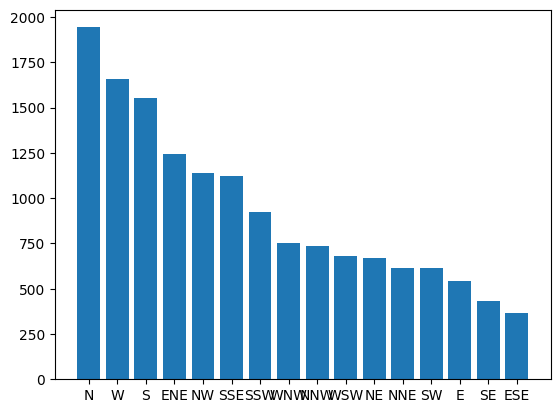

In [ ]:
wind_direction_counts = df["WindGustDir"].value_counts()

plt.bar(wind_direction_counts.index, wind_direction_counts.values)
plt.show()

In [ ]:
df.Location.sort_values().unique()

array(['Canberra', 'Melbourne', 'MelbourneAirport', 'Sydney',
       'SydneyAirport'], dtype=object)

Hasta el momento utilizamos 4 metodos para rellenar los datos faltantes.
1. Interpolacion: Lo quehace este metodo que es nos rellena el dato faltante con el promedio de el dato de arriba y el del dato de abajo. Si no tiene datos en la fila de arriba o abajo, busca el calor mas ceracano y reemplaza con ese promedio.
2. Funcion de rellenado para las variables discretas donde utilizamos la moda en base a la localidad y la estacion del año.
3. Funcion de rellenado de variables continuas donde utilizamos el promedio en base a la localidad y la estacion del año.
4. (fill missing data) esta funcion completa dependiendo el mes (asi es mas acertivo)

#2. Visualizaciones

In [ ]:
def create_histograms_by_location(df):
    """
    Crea histogramas por cada columna del DataFrame para cada localidad y los muestra uno al lado del otro.

    Args:
    - df: DataFrame de pandas.

    Returns:
    - None (muestra los histogramas uno al lado del otro).
    """
    locations = df['Location'].unique()

    column_names = df.columns.difference(['Location', 'Date'])

    num_locations = len(locations)
    num_columns = len(column_names)
    fig, axes = plt.subplots(num_columns, num_locations, figsize=(5 * num_locations, 5 * num_columns))

    for i, column_name in enumerate(column_names):
        for j, location in enumerate(locations):
            ax = axes[i, j]

            data = df[(df['Location'] == location)][column_name]

            ax.hist(data, bins=20, edgecolor='black')
            ax.set_title(f'Histograma de {column_name} en {location}')
            ax.set_xlabel(column_name)
            ax.set_ylabel('Frecuencia')

    plt.tight_layout()

    plt.show()

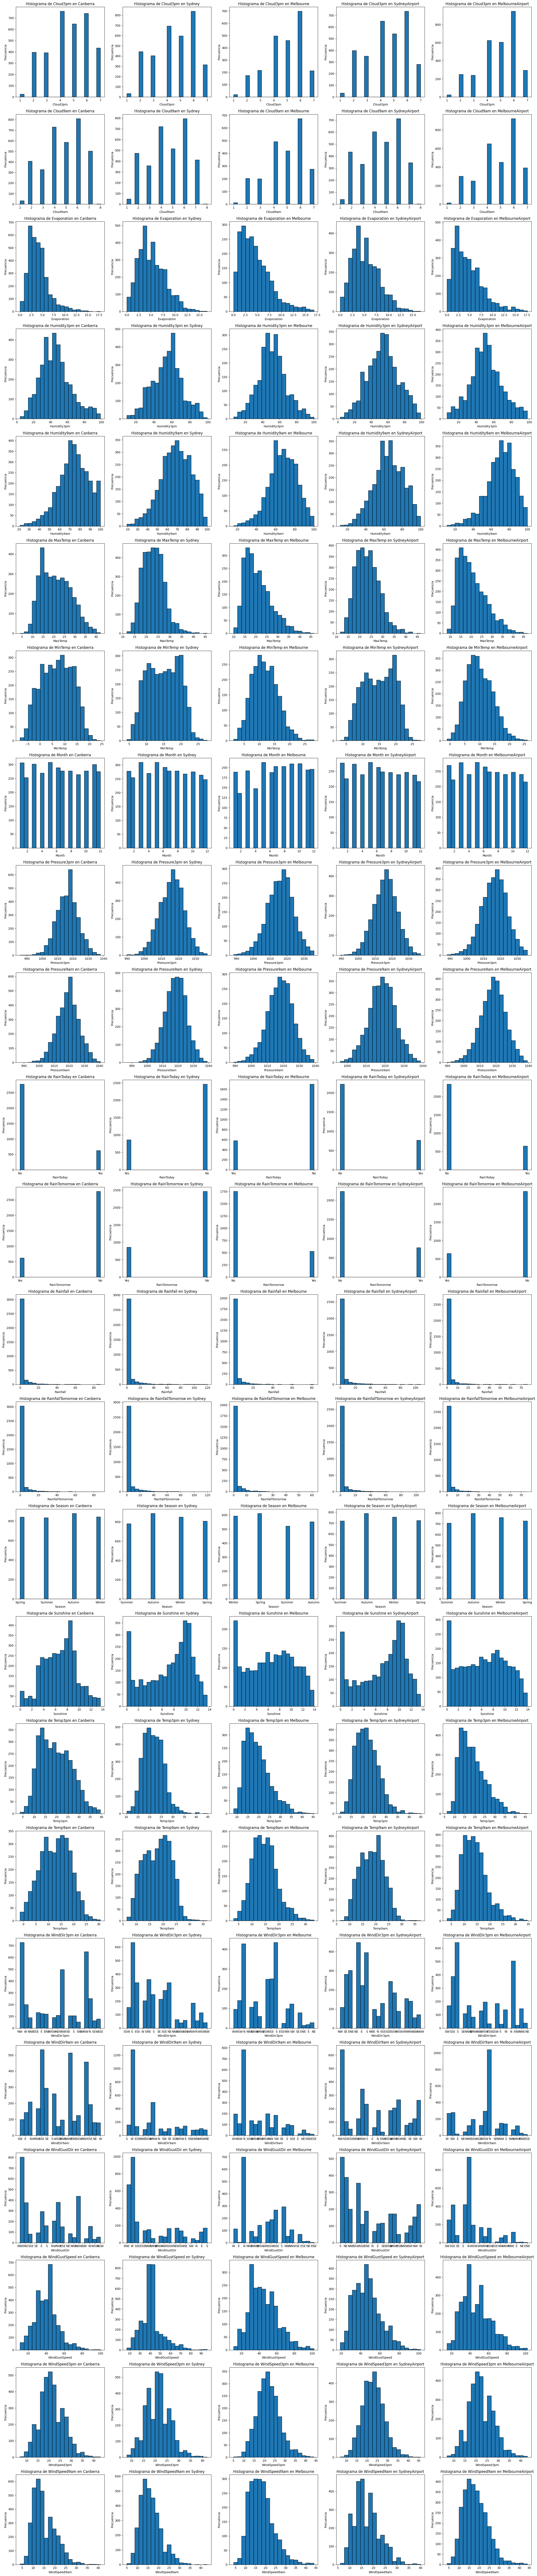

In [ ]:
create_histograms_by_location(df)

Vamos a realizar un grafico preguntandonos cuanto llueve (en proporcion) en cada estacion dependiendo de la localidad

In [ ]:
lluvia_localidad_estacion=df[["Location","RainfallTomorrow","Season"]]

In [ ]:
lluvia_localidad_estacion = lluvia_localidad_estacion.groupby(['Location', 'Season'])['RainfallTomorrow'].sum().reset_index()

In [ ]:
lluvia_localidad_estacion

,Location,Season,RainfallTomorrow
0,Canberra,Autumn,1113.1
1,Canberra,Spring,1677.0
2,Canberra,Summer,1854.6
3,Canberra,Winter,1227.9
4,Melbourne,Autumn,762.4
5,Melbourne,Spring,1188.8
6,Melbourne,Summer,661.0
7,Melbourne,Winter,860.8
8,MelbourneAirport,Autumn,1034.0
9,MelbourneAirport,Spring,1443.8


In [ ]:
suma_total_por_localidad = lluvia_localidad_estacion.groupby('Location')['RainfallTomorrow'].sum().reset_index()
lluvia_localidad_estacion = lluvia_localidad_estacion.merge(suma_total_por_localidad, on='Location', suffixes=('', '_total'))
lluvia_localidad_estacion['Proportion'] = lluvia_localidad_estacion['RainfallTomorrow'] / lluvia_localidad_estacion['RainfallTomorrow_total']
lluvia_localidad_estacion = lluvia_localidad_estacion.drop('RainfallTomorrow_total', axis=1)

lluvia_localidad_estacion

,Location,Season,RainfallTomorrow,Proportion
0,Canberra,Autumn,1113.1,0.189541
1,Canberra,Spring,1677.0,0.285563
2,Canberra,Summer,1854.6,0.315806
3,Canberra,Winter,1227.9,0.209090
4,Melbourne,Autumn,762.4,0.219522
5,Melbourne,Spring,1188.8,0.342298
6,Melbourne,Summer,661.0,0.190325
7,Melbourne,Winter,860.8,0.247855
8,MelbourneAirport,Autumn,1034.0,0.240443
9,MelbourneAirport,Spring,1443.8,0.335736


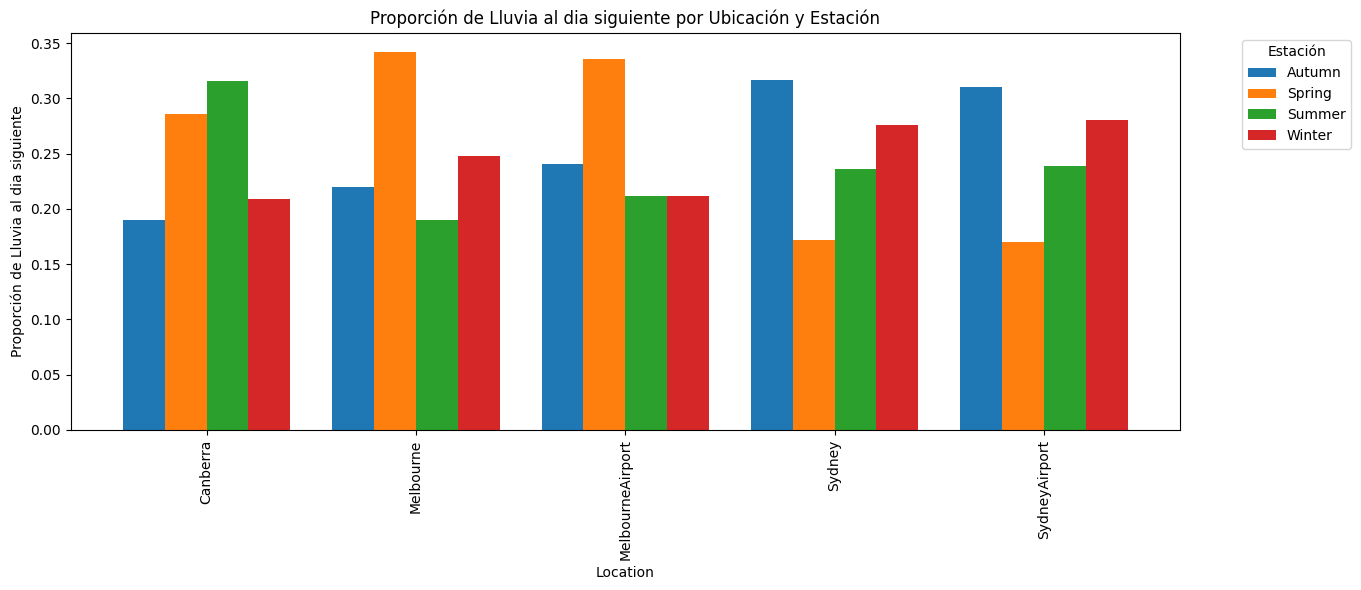

In [ ]:
pivoteado = lluvia_localidad_estacion.pivot(index='Location', columns='Season', values='Proportion')
ax = pivoteado.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.xlabel('Location')
plt.ylabel('Proporción de Lluvia al dia siguiente')
plt.title('Proporción de Lluvia al dia siguiente por Ubicación y Estación')
plt.tight_layout()
plt.legend(title='Estación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Con esto nos damos cuenta que vamos a tener que tener en cuenta la localidad y la estacion a la hora de evaluar de hacer uno o varios modelos predictivos porque lo que sucede es que en cada region es diferente en que estacion del año llueve mas. En Canberra llueve mas en verano mientras que en Melbourne llueve mas en primavera. En la otra vereda en Sydney llueve mas en Otoño.

Vamos a realizar una comparacion de la velocidad del viento dependiendo si llueve o no llueve. Para esto tendremos en cuenta localidad y estacion (al menos a la hora de realizar el df)

In [ ]:
lluvia_hoy=df[df["RainTomorrow"]=="Yes"]
lluvia_hoy=lluvia_hoy[["Location","WindGustSpeed","Season"]]
lluvia_hoy=lluvia_hoy.groupby(["Location","Season"])["WindGustSpeed"].mean().reset_index()
lluvia_hoy.rename(columns={"WindGustSpeed":"Wind Speed Rain"},inplace=True)

In [ ]:
no_lluvia_hoy=df[df["RainTomorrow"]=="No"]
no_lluvia_hoy=no_lluvia_hoy[["Location","WindGustSpeed","Season"]]
no_lluvia_hoy=no_lluvia_hoy.groupby(["Location","Season"])["WindGustSpeed"].mean().reset_index()
no_lluvia_hoy["Wind Speed Rain"]=lluvia_hoy["Wind Speed Rain"]
no_lluvia_hoy.rename(columns={"WindGustSpeed":"Wind Speed No Rain"},inplace=True)

In [ ]:
no_lluvia_hoy

,Location,Season,Wind Speed No Rain,Wind Speed Rain
0,Canberra,Autumn,34.863423,41.714286
1,Canberra,Spring,43.757340,48.293212
2,Canberra,Summer,43.201919,46.140380
3,Canberra,Winter,35.652506,43.202720
4,Melbourne,Autumn,38.912833,49.815563
5,Melbourne,Spring,46.354716,55.021567
6,Melbourne,Summer,44.289195,50.320988
7,Melbourne,Winter,42.305761,51.825301
8,MelbourneAirport,Autumn,41.703245,52.756045
9,MelbourneAirport,Spring,47.723090,54.734386


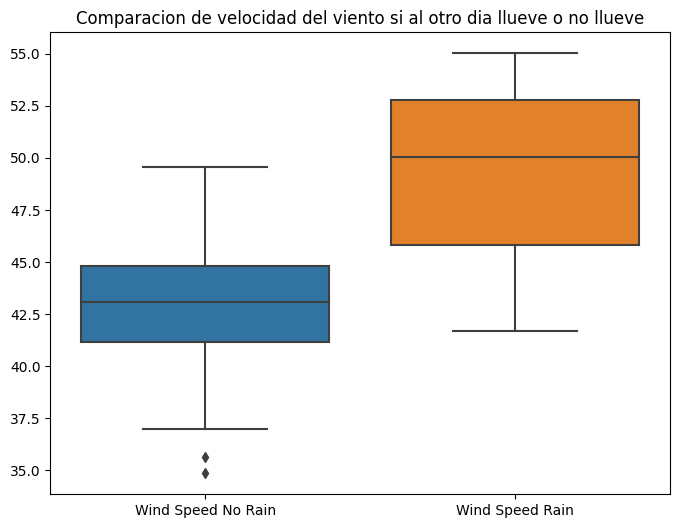

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=no_lluvia_hoy[['Wind Speed No Rain', 'Wind Speed Rain']])
plt.title('Comparacion de velocidad del viento si al otro dia llueve o no llueve')
plt.show()

Podemos ver que cuando al dia siguiente llueve, la velocidad promedio del viento es mayor a que cuando no llueve.

Ahora vamos a ver la relacion que hay entre la temperatura maxima y cuanto llueve al otro dia dependiendo de la localidad y las estaciones. Entendiendo como hipotesis que si hace mucho calor hoy, mañana deberia llover


In [ ]:
temperatura_maxima=df[["Location","Season","MaxTemp","RainTomorrow","RainfallTomorrow"]]

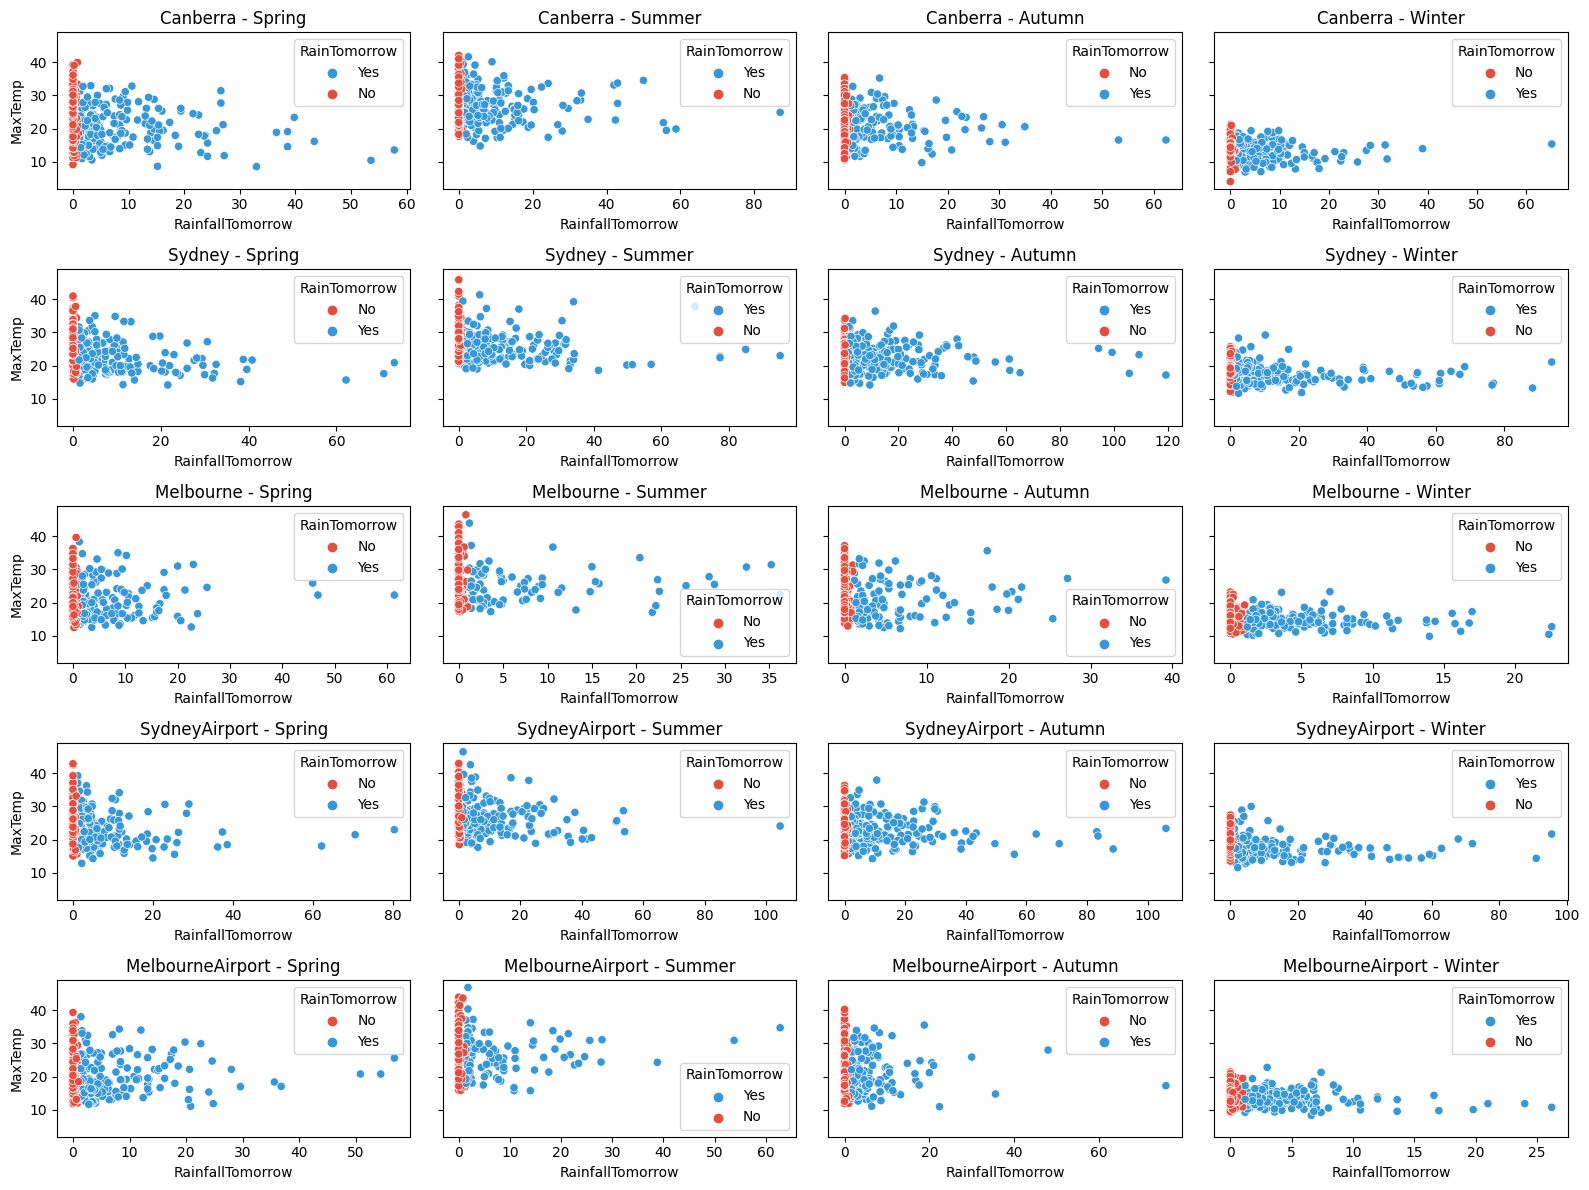

In [ ]:
colores = {'Yes': '#3498db', 'No': '#e74c3c'}

ubicaciones = temperatura_maxima['Location'].unique()
estaciones = temperatura_maxima['Season'].unique()

n_filas = len(ubicaciones)
n_columnas = len(estaciones)

fig, axes = plt.subplots(n_filas, n_columnas, figsize=(16, 12), sharey=True)

for i, ubicacion in enumerate(ubicaciones):
    for j, estacion in enumerate(estaciones):
        ax = axes[i, j]
        datos = temperatura_maxima[(temperatura_maxima['Location'] == ubicacion) & (temperatura_maxima['Season'] == estacion)]
        sns.scatterplot(data=datos, x='RainfallTomorrow', y='MaxTemp', hue='RainTomorrow', palette=colores, ax=ax)
        ax.set_title(f'{ubicacion} - {estacion}')
        ax.set_xlabel('RainfallTomorrow')
        ax.set_ylabel('MaxTemp')

plt.tight_layout()
plt.show()


Con la matriz de scatterplots anterior podemos ver como no necesariamente si hace calor un dia al otro va a llover. Para realizar este scatterplot nos parecio necesario separar por estaciones y obviamente por localidades. Algo que nos gustaria destacar es que si bien hay dias donde hace frio y al otro dia llueve, esto podria ser porque muchas veces lo que sucede es que llueve un dia y al otro tambien llueve, vamos a ver en el siguiente grafico acerca de un poco mas de esto

In [ ]:
llueve_mañana=df[["RainToday","RainTomorrow"]]
llueve_mañana=llueve_mañana.groupby(["RainToday","RainTomorrow"]).value_counts().reset_index()
llueve_mañana.rename(columns={0:"count"},inplace=True)

In [ ]:
llueve_mañana

,RainToday,RainTomorrow,count
0,No,No,9560
1,No,Yes,1941
2,Yes,No,2001
3,Yes,Yes,1486


In [ ]:
llueve_hoy_yes=llueve_mañana[llueve_mañana["RainToday"]=="Yes"]
llueve_hoy_yes["Proporcion"]=llueve_hoy_yes["count"]/llueve_hoy_yes["count"].sum()
llueve_hoy_No=llueve_mañana[llueve_mañana["RainToday"]=="No"]
llueve_hoy_No["Proporcion"]=llueve_hoy_No["count"]/llueve_hoy_No["count"].sum()

<ipython-input-113-f2f439a03b11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llueve_hoy_yes["Proporcion"]=llueve_hoy_yes["count"]/llueve_hoy_yes["count"].sum()
<ipython-input-113-f2f439a03b11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llueve_hoy_No["Proporcion"]=llueve_hoy_No["count"]/llueve_hoy_No["count"].sum()


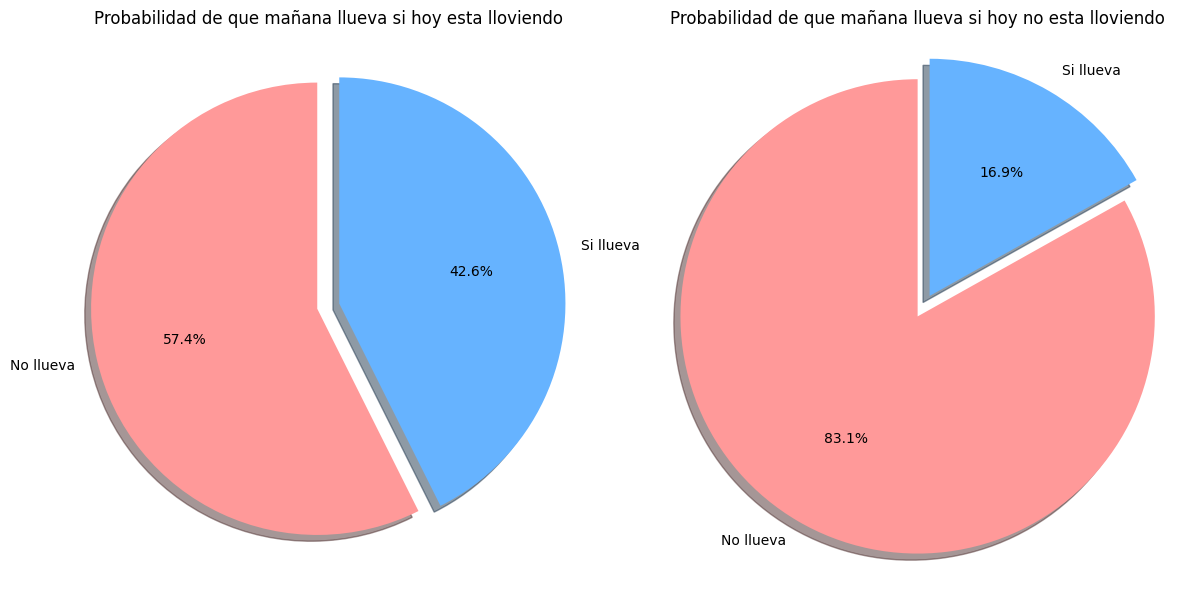

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

labels_yes = 'No llueva', 'Si llueva'
sizes_yes = [llueve_hoy_yes["Proporcion"].iloc[0], llueve_hoy_yes["Proporcion"].iloc[1]]
colors_yes = ['#ff9999', '#66b3ff']
explode_yes = (0.1, 0)

labels_no = 'No llueva', 'Si llueva'
sizes_no = [llueve_hoy_No["Proporcion"].iloc[0], llueve_hoy_No["Proporcion"].iloc[1]]
colors_no = ['#ff9999', '#66b3ff']
explode_no = (0.1, 0)

axes[0].pie(sizes_yes, explode=explode_yes, labels=labels_yes, colors=colors_yes, autopct='%1.1f%%', shadow=True, startangle=90)
axes[0].axis('equal')
axes[0].set_title('Probabilidad de que mañana llueva si hoy esta lloviendo')

axes[1].pie(sizes_no, explode=explode_no, labels=labels_no, colors=colors_no, autopct='%1.1f%%', shadow=True, startangle=90)
axes[1].axis('equal')
axes[1].set_title('Probabilidad de que mañana llueva si hoy no esta lloviendo')

plt.tight_layout()
plt.show()

Con esto podemos confirmar lo dicho anteriormente, si hoy esta lloviendo hay una probabilidade de que mañana continue lloviendo mayor a la que si hoy no esta lloviendo, mañana llueva.

Vamos a ver cuanto llovera mañana en promedio si hoy esta lloviendo  

In [ ]:
cant_lluvia=df[["RainfallTomorrow","RainToday","RainTomorrow","Location"]]
cant_lluvia=cant_lluvia[(cant_lluvia["RainToday"]=="Yes")&(cant_lluvia["RainTomorrow"]=="Yes")]
cant_lluvia

,RainfallTomorrow,RainToday,RainTomorrow,Location
45574,3.6,Yes,Yes,Canberra
45575,39.8,Yes,Yes,Canberra
45576,2.8,Yes,Yes,Canberra
45603,4.2,Yes,Yes,Canberra
45618,1.4,Yes,Yes,Canberra
...,...,...,...,...
36502,15.6,Yes,Yes,SydneyAirport
33494,38.8,Yes,Yes,Sydney
36503,2.4,Yes,Yes,SydneyAirport
33495,2.8,Yes,Yes,Sydney


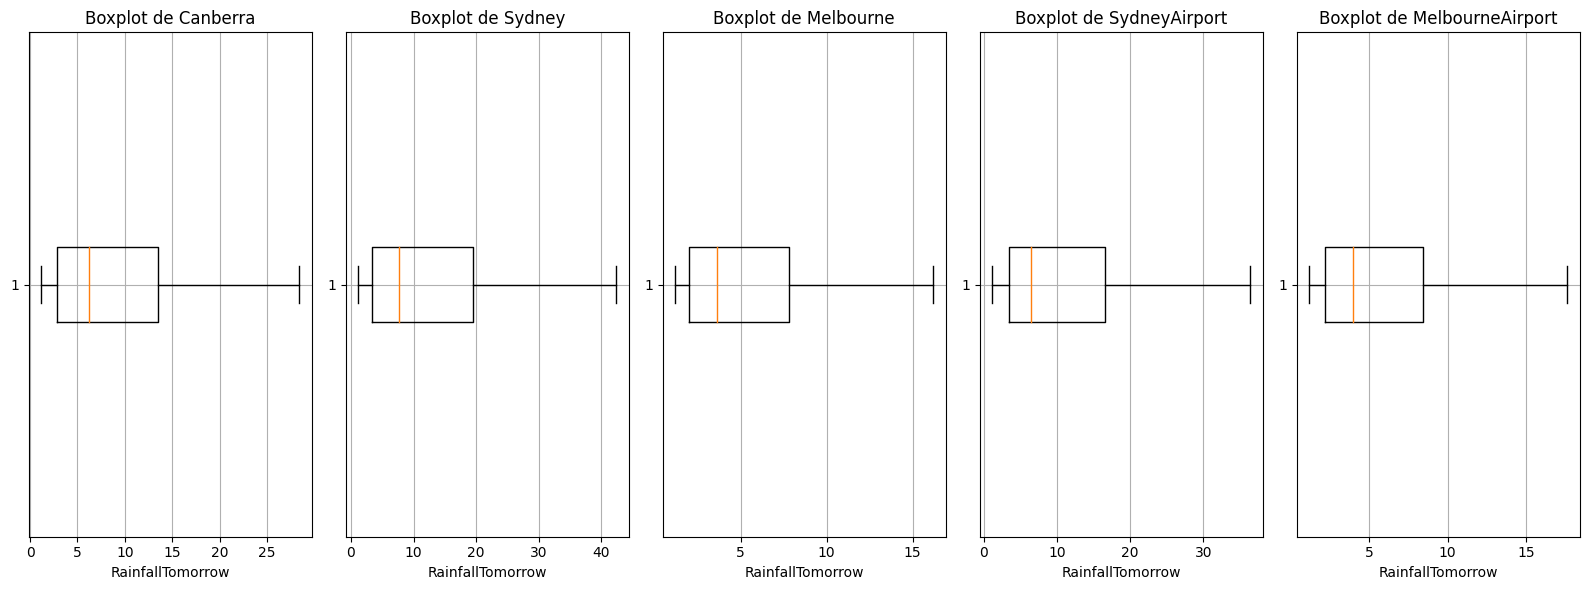

In [ ]:
ubicaciones = cant_lluvia['Location'].unique()

plt.figure(figsize=(16, 6))

for i, ubicacion in enumerate(ubicaciones, 1):
    plt.subplot(1, len(ubicaciones), i)
    datos_ubicacion = cant_lluvia[cant_lluvia['Location'] == ubicacion]['RainfallTomorrow']
    plt.boxplot(datos_ubicacion, vert=False, showfliers=False)
    plt.title(f'Boxplot de {ubicacion}')
    plt.xlabel('RainfallTomorrow')
    plt.grid(True)

plt.tight_layout()

plt.show()

Podemos ver como la cantidad de lluvia que caera mañana dependiendo de si hoy llovio en Sydney es mayor que todos los demas lugares mientras que Melbourne es donde menos llueve.

Cual es la direccion del viento que probabilidad hay de que llueva dependiendo del lugar?

In [ ]:
viento_lluvia=df[["Location","Season","WindGustDir","RainTomorrow"]]
viento_lluvia=viento_lluvia[viento_lluvia["RainTomorrow"]=="Yes"]
viento_lluvia = viento_lluvia.groupby('Location')['WindGustDir'].value_counts().groupby(level=0, group_keys=False).nlargest(5).reset_index(name='Count')

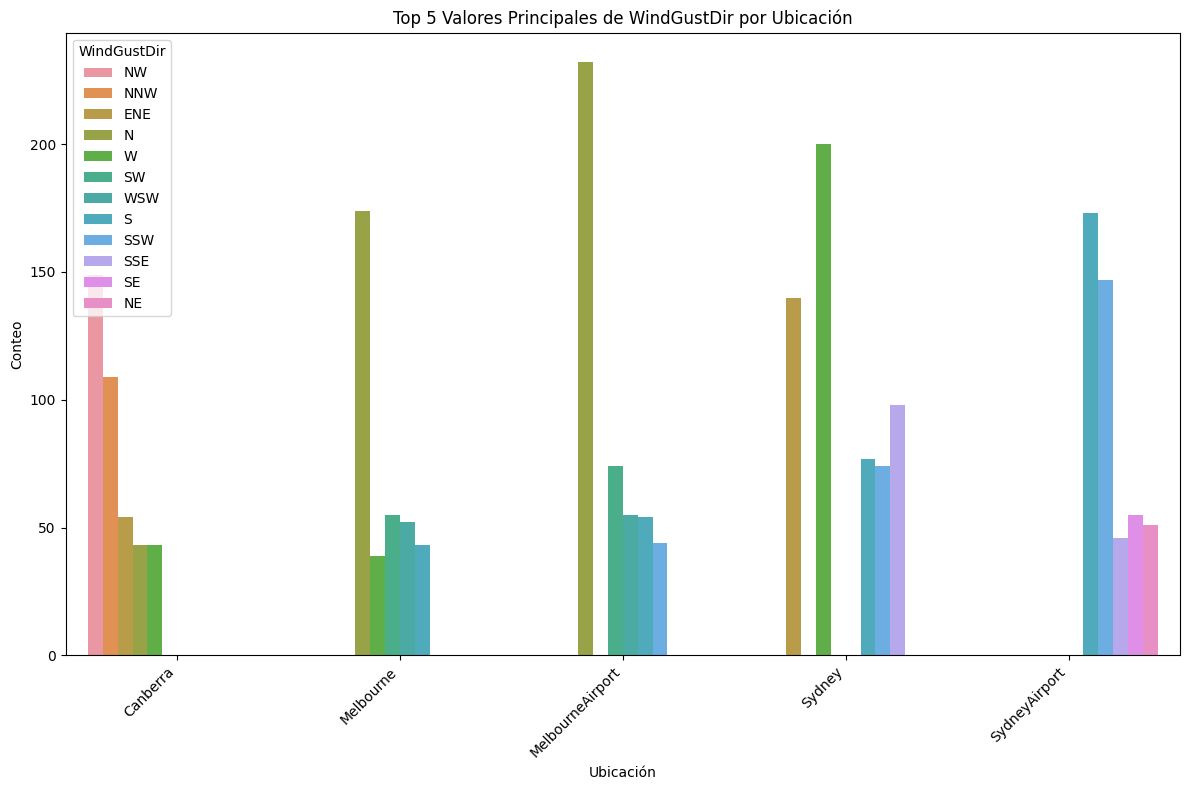

In [ ]:
plt.figure(figsize=(12, 8))

sns.barplot(x='Location', y='Count', hue='WindGustDir', data=viento_lluvia)
plt.title('Top 5 Valores Principales de WindGustDir por Ubicación')
plt.xlabel('Ubicación')
plt.ylabel('Conteo')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Bueno podemos ver que de donde viene el viento claramente influye aunque es una realidad tambien que anteriormente decidimos rellenar los valores faltantes con la moda del lugar dependiendo la estacion por lo tanto este grafico claramente puede estar sesgado.

# 3. Codificación de variables categóricas

In [ ]:
def create_dummy_variables(df, column_name):
    """
    Genera variables dummy para los valores únicos en una columna categórica del DataFrame.

    Args:
    - df: DataFrame de pandas.
    - column_name: Nombre de la columna para la cual se generarán las variables dummy.

    Returns:
    - DataFrame modificado con las variables dummy.
    """
    dummies = pd.get_dummies(df[column_name], prefix=column_name, drop_first=True)

    df = pd.concat([df, dummies], axis=1)

    df.drop(column_name, axis=1, inplace=True)

    return df


In [ ]:
df_cp = df.copy()

df_cp = create_dummy_variables(df_cp, 'Location')
df_cp = create_dummy_variables(df_cp, 'Season')
df_cp = create_dummy_variables(df_cp, 'WindGustDir')
df_cp = create_dummy_variables(df_cp, 'WindDir3pm')
df_cp = create_dummy_variables(df_cp, 'WindDir9am')

df_cp['RainToday'] = df_cp['RainToday'].replace({'Yes': 1, 'No': 0})

df_cp['RainTomorrow'] = df_cp['RainTomorrow'].replace({'Yes': 1, 'No': 0})

df_cp.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW
45573,2007-11-01,8.0,24.3,0.0,3.4,6.3,30.0,9,20,68.0,...,0,0,0,0,0,0,1,0,0,0
45574,2007-11-02,14.0,26.9,3.6,4.4,9.7,39.0,9,14,80.0,...,0,0,0,0,0,0,0,0,0,0
45575,2007-11-03,13.7,23.4,3.6,5.8,3.3,85.0,17,18,82.0,...,0,0,0,0,0,0,0,0,0,0
45576,2007-11-04,13.3,15.5,39.8,7.2,9.1,54.0,23,25,62.0,...,0,0,0,0,0,0,0,0,1,0
45577,2007-11-05,7.6,16.1,2.8,5.6,10.6,50.0,19,26,68.0,...,0,0,0,0,1,0,0,0,0,0


#4. Balanceo Del Dataset


veremos si el dataframe esta balanceado o no. Esto siempre es viendolo con nuestra variable objetivo o sea la que queremos predecir

In [ ]:
df_cp["RainTomorrow"].value_counts()

0    11561
1     3427
Name: RainTomorrow, dtype: int64

Claramente el dataframe esta desbalanceado ya que con esto nos va a predecir mejor cuando no llueve que cuando llueve y cuanto llueve.

In [ ]:
# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_cp.drop(["RainTomorrow", "Date"], axis=1)
y = df_cp["RainTomorrow"]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para el sobremuestreo
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts()

0    9239
1    9239
Name: RainTomorrow, dtype: int64

In [ ]:
df_cp = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
df_cp

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,RainTomorrow
0,17.400000,26.400000,0.000000,7.200000,10.600000,46.000000,11,28,62.000000,50.000000,...,0,0,0,0,0,0,0,0,0,0
1,17.300000,27.600000,29.400000,4.600000,7.500000,44.414384,21,23,70.000000,59.000000,...,0,0,0,0,0,0,0,1,0,0
2,5.900000,20.300000,0.000000,1.600000,9.300000,26.000000,6,21,97.000000,53.000000,...,0,0,0,0,0,0,0,0,0,0
3,13.100000,21.300000,0.000000,5.400000,12.200000,41.000000,11,23,39.000000,40.000000,...,0,0,0,0,1,0,0,0,0,0
4,2.700000,14.400000,0.000000,3.749899,6.248790,44.000000,30,28,59.000000,51.000000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18473,18.184795,23.423578,3.907978,1.993918,0.000000,43.944490,13,18,92.000000,79.224329,...,0,0,0,0,0,0,0,0,0,1
18474,10.054016,14.988294,0.600000,1.455853,2.857690,37.324408,15,21,89.000000,76.603674,...,0,0,0,0,0,0,0,0,0,1
18475,11.994388,16.067985,1.420791,5.600000,2.682336,53.688134,14,27,78.424104,44.896045,...,0,0,0,0,0,0,0,0,0,1
18476,12.450657,21.208685,0.000000,8.151578,6.876710,49.456577,22,30,44.621055,45.077632,...,0,0,0,0,0,0,0,0,0,1


# 5. Matriz de correlación

1.   MinTemp y Temp9am estan muy correlacionadas (de todas las temperaturas, mintemp es la que mejor se correlaciona con rainfall tomorrow
2.   MaxTemp y Temp3pm estan muy correlacionadas
3.   Pressure9am y Pressure3pm tambien muy correlacionadas
4.   Windspeed9am y windspeed3pm lo podriamos sacar al menos para probar






### Hay que sacar una de las variables muy relacionadas siempre que no sea la variable que queremos explicar

In [ ]:
def correlated_variables(df, target_column, min_correlation=0.04):

    correlations = df.corr()[target_column].drop(target_column)

    filtered_correlations = correlations[correlations.abs() > min_correlation]

    if filtered_correlations.empty:
        print("No se encontraron variables con correlación mayor que el umbral especificado.")
        return {}

    correlated_variables = filtered_correlations.to_dict()

    return correlated_variables

def plot_correlation_graph(correlation_dict, target_column):
    if not correlation_dict:
        print("El diccionario de correlaciones está vacío. No se puede generar un gráfico.")
        return

    correlation_dict.pop(target_column, None)

    sorted_corr_df = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Correlation'])
    sorted_corr_df['Correlation'] = sorted_corr_df['Correlation'].abs()

    sorted_corr_df = sorted_corr_df.sort_values(by='Correlation', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=sorted_corr_df.index, y='Correlation', data=sorted_corr_df, palette='viridis')
    plt.title(f'Relación (valor absoluto) entre variables y {target_column}')
    plt.xticks(rotation=90)
    plt.show()

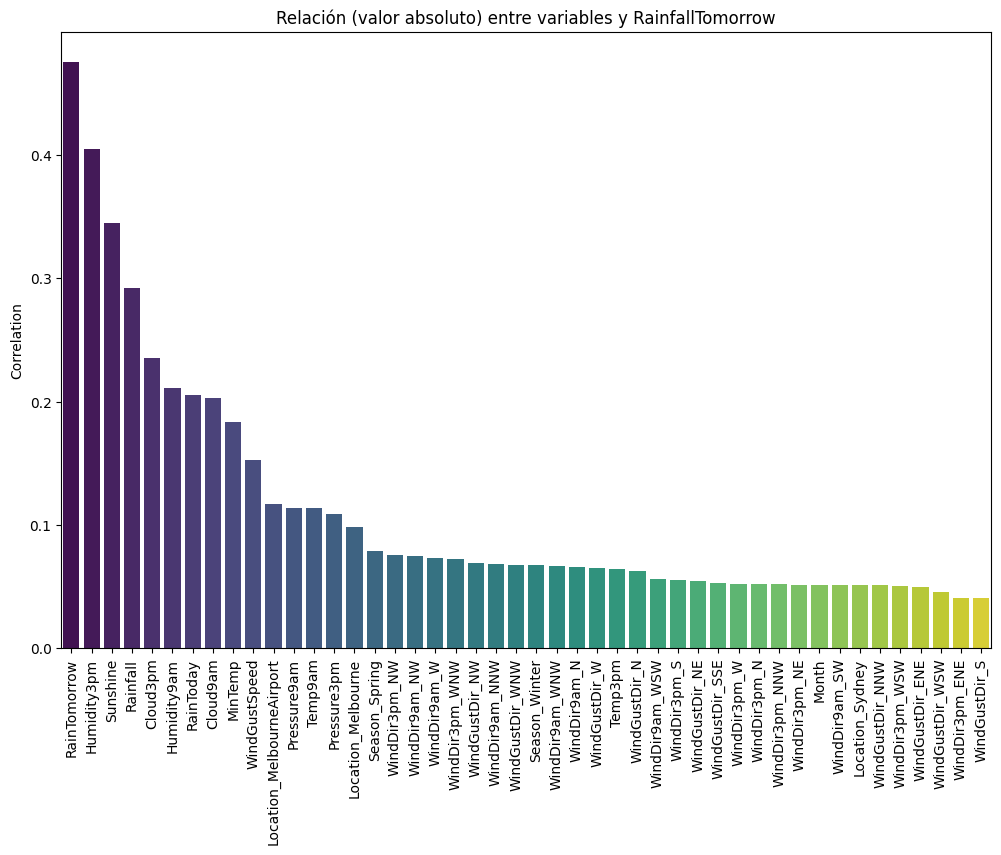

In [ ]:
correlated_vars = correlated_variables(df_cp, 'RainfallTomorrow', 0.04)
plot_correlation_graph(correlated_vars, 'RainfallTomorrow')

# 6. Eleccion de features para nuestro modelo (feature engineering)

En base a todo lo previo que vimos anteriormente, vamos a realizar la seleccion de las caracteristicas de nuestro primer modelo de regresion lineal.

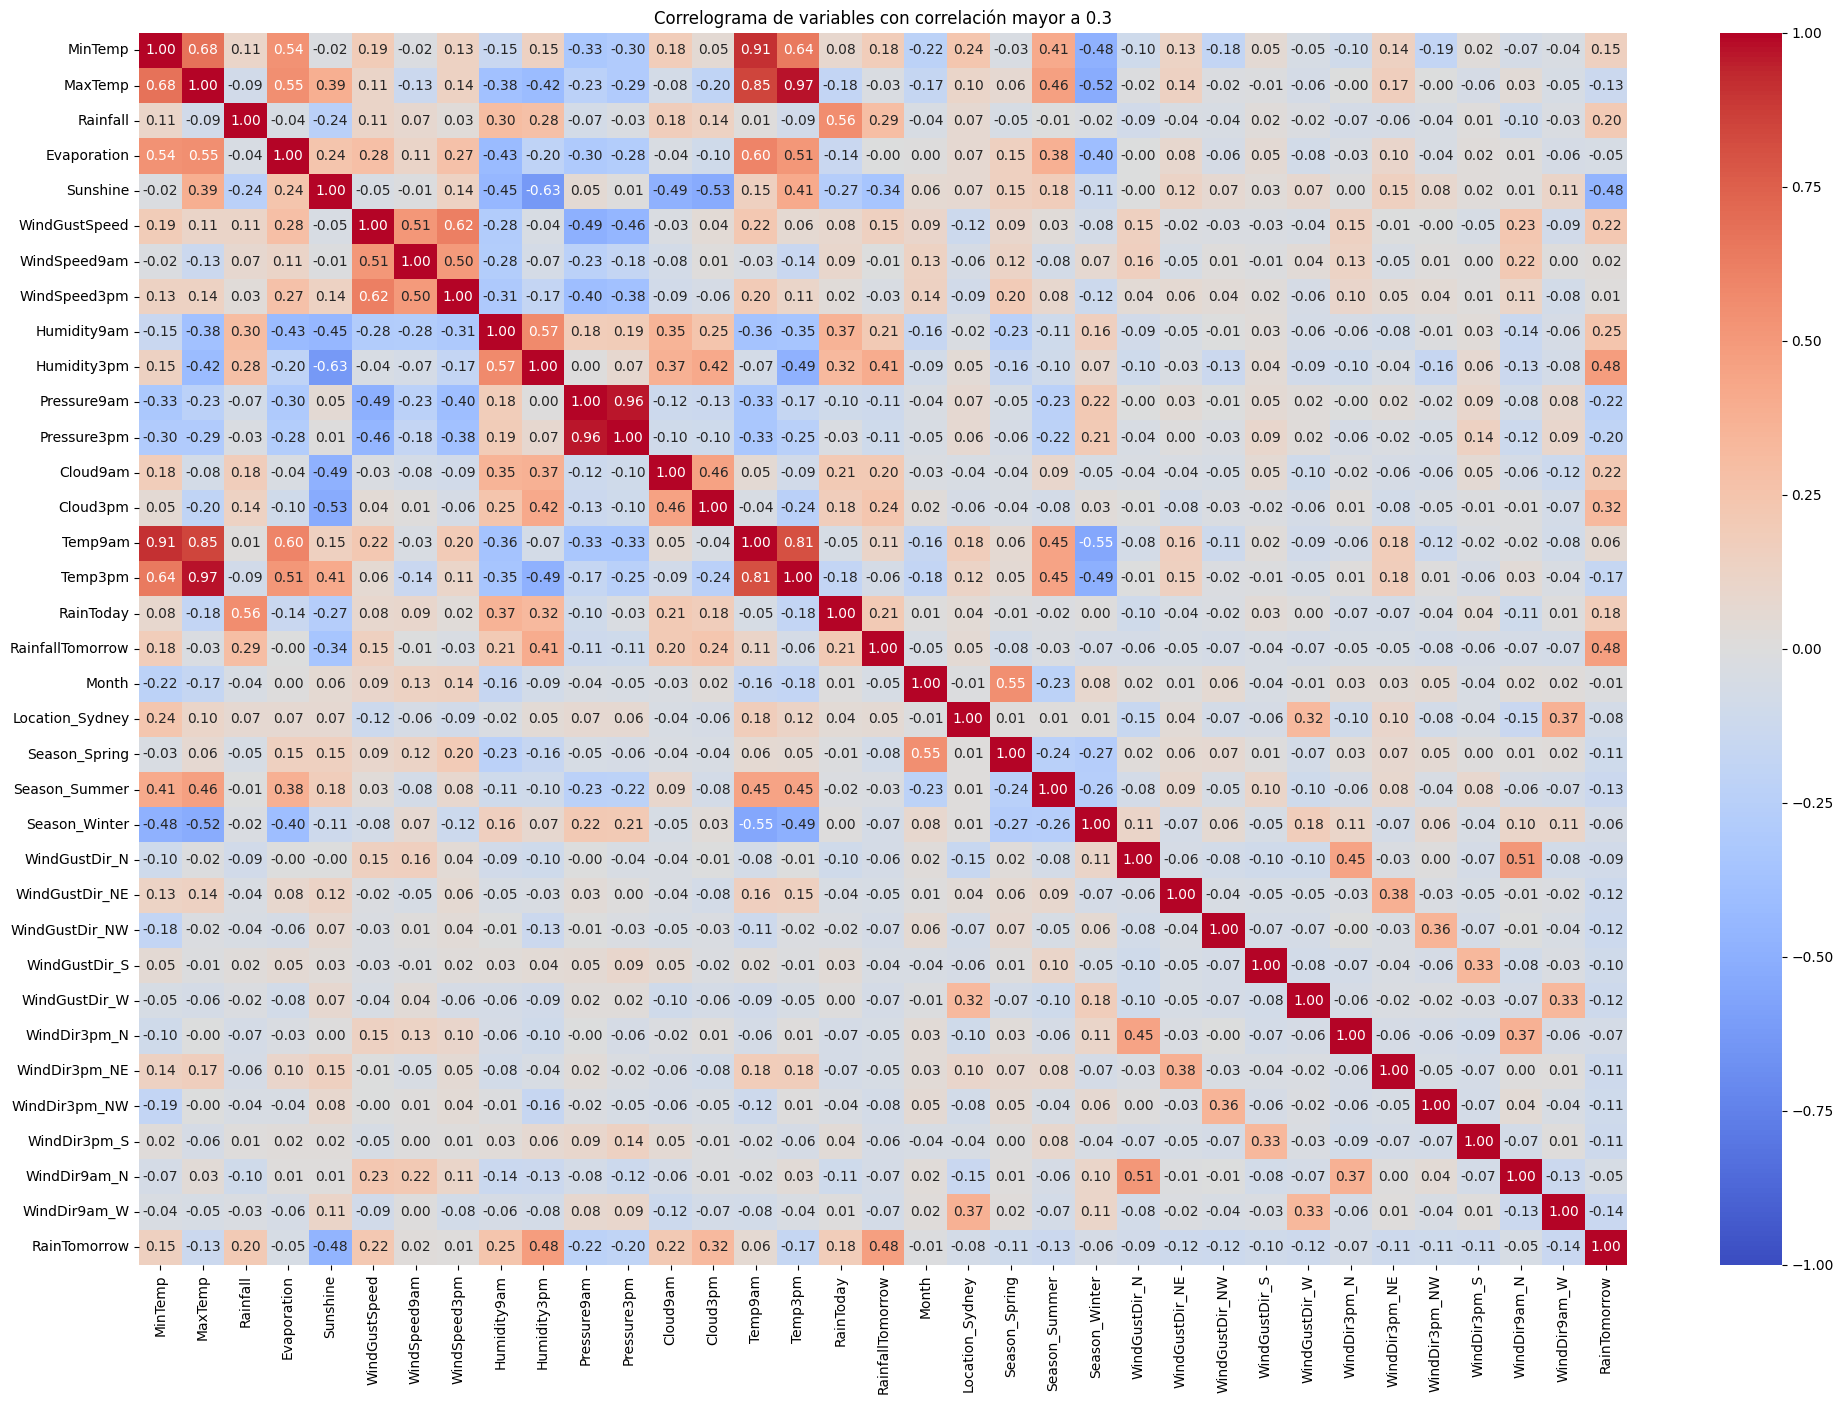

In [ ]:
def generate_correlogram(df, threshold = 0.4):
    # Calcula la matriz de correlación
    corr_matrix = df.corr()

    # Filtra las correlaciones mayores al umbral y diferentes de 1 (diagonal)
    high_corr = (corr_matrix.abs() > threshold) & (corr_matrix != 1)

    # Crea una matriz con True si hay una alta correlación y False en otro caso
    mask = high_corr.values

    # Establece las diagonales de la matriz en False
    for i in range(mask.shape[0]):
        mask[i, i] = False

    # Filtra las etiquetas de filas y columnas basadas en el filtro
    filtered_labels = [label for i, label in enumerate(corr_matrix.columns) if any(mask[i])]

    # Utiliza seaborn para crear el correlograma con etiquetas filtradas
    plt.figure(figsize=(24, 16))
    sns.heatmap(corr_matrix.loc[filtered_labels, filtered_labels], annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlograma de variables con correlación mayor a {threshold}')
    plt.show()

# Ejemplo de uso:
generate_correlogram(df_cp, 0.3)

#Regresion Lineal

###Primer modelo:

Para este primer modelo utilizaremos aquellas variables que consideramos utiles. Por eemplo en aquellas variables que tienen 2 horas diferentes del dia solamente utilizaremos las de las 3pm y en temperatura la minima del dia.

In [ ]:
primer_modelo = df_cp[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'RainfallTomorrow', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter','RainTomorrow']]


X = primer_modelo[['MinTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed3pm',
       'Humidity3pm', 'Pressure3pm', 'Cloud3pm',
        'Temp3pm', 'RainToday', 'Month',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Sydney',
       'Location_SydneyAirport', 'Season_Spring', 'Season_Summer',
       'Season_Winter','RainTomorrow']]
y = primer_modelo['RainfallTomorrow']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo de regresión lineal
reg = LinearRegression()
reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = reg.predict(X_test)

# Calcular métricas de evaluación

mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse.round(4))

mae=mean_absolute_error(y_test, y_pred)
print("MAE:",mae.round(4))

reg.score(X_train,y_train), reg.score(X_test,y_test)
print(f"""El R² para los datos de entrenamiento es: {reg.score(X_train,y_train).round(4)} y para los de testeo: {reg.score(X_test,y_test).round(4)}""")

mape = (mae / (y_test)).mean() * 100
print("MAPE:",mape.round(4))

Error cuadrático medio: 55.3781
MAE: 4.1371
El R² para los datos de entrenamiento es: 0.3242 y para los de testeo: 0.3188
MAPE: inf


###Segundo modelo:

Para este segundo modelo utilizaremos las variables cuya correlacion es mayor a 0.2, paea esto utilizamos la funcion correlated_variables para obtener una lista de las mismas

In [ ]:
selected_features = list(correlated_variables(df_cp, 'RainfallTomorrow', 0.2).keys())

selected_features.remove('RainTomorrow')

tercer_modelo = df_cp[selected_features + ['RainfallTomorrow', 'RainTomorrow']]

columnas_numericas = tercer_modelo.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()

tercer_modelo[columnas_numericas] = scaler.fit_transform(df_cp[columnas_numericas])

X = tercer_modelo[selected_features]
y = tercer_modelo[['RainfallTomorrow', 'RainTomorrow']]

<ipython-input-131-03329015bc42>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tercer_modelo[columnas_numericas] = scaler.fit_transform(df_cp[columnas_numericas])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse.round(4))

mae=mean_absolute_error(y_test, y_pred)
print("MAE:",mae.round(4))

reg.score(X_train,y_train), reg.score(X_test,y_test)
print(f"""El R² para los datos de entrenamiento es: {reg.score(X_train,y_train).round(4)} y para los de testeo: {reg.score(X_test,y_test).round(4)}""")

mape = (mae / (y_test)).mean() * 100
print("MAPE:",mape.round(4))

Error cuadrático medio: 0.4568
MAE: 0.4284
El R² para los datos de entrenamiento es: 0.2566 y para los de testeo: 0.2509
MAPE: RainfallTomorrow   -58.1487
RainTomorrow            inf
dtype: float64


### Tercer modelo

Para este tercer modelo utilizamos aquellas variables que tengan una correlacion mayor de 0.06. Este va a ser el mejor modelo que obtengamos y tambien en base a este haremos las regularizaciones

In [ ]:
selected_features = list(correlated_variables(df_cp, 'RainfallTomorrow', 0.06).keys())


tercer_modelo = df_cp[selected_features + ['RainfallTomorrow']]

columnas_numericas = tercer_modelo.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()

tercer_modelo[columnas_numericas] = scaler.fit_transform(df_cp[columnas_numericas])

X = tercer_modelo[selected_features]
y = tercer_modelo['RainfallTomorrow']

<ipython-input-155-3158c0f1df62>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tercer_modelo[columnas_numericas] = scaler.fit_transform(df_cp[columnas_numericas])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = reg.predict(X_test)

print("Predicciones: {}, Valores actuales: {}".format(y_pred[:5], y_test[:5]))

Predicciones: [ 0.61187705  0.95155687 -0.24505291  0.43918312 -0.562846  ], Valores actuales: 12422    0.163680
12612    0.123061
9937    -0.483284
17617    0.356025
1510    -0.483284
Name: RainfallTomorrow, dtype: float64


Obtenemos el Error Cuadratico Medio (Mean Squared Error): Esta metrica mide el promedio de los cuadrados de las diferencias entre los valores reales y las predicciones del modelo

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print("Error cuadrático medio:", mse.round(4))

Error cuadrático medio: 0.6239


Calculamos el Error Absoluto Medio (Mean Absolute Error) es similar al MSE pero en vez de elevar al cuadrado, toma el valor absoluto de las diferencias entre los valores reales y las predicciones

In [ ]:
mae=mean_absolute_error(y_test, y_pred)
print("MAE:",mae.round(4))

MAE: 0.4449


Ahora obtenemos el Coeficiente de determinacion R². Este se utiliza para calcular la puntuacion de precision del modelo en un conjunto de datos. La puntuacion suele representar que tan bien se ajusta el modelo a los datos reales.


*   R² =1 El modelo explica perfectamente toda la variabilidad en la variable dependiente
*   R² = 0: El modelo no explica nada de la variabilidad en la variable dependiente.

Lo hacemos para los datos de testeo y entrenamiento

In [ ]:
reg.score(X_train,y_train), reg.score(X_test,y_test)
print(f"El R² para los datos de entrenamiento es: {reg.score(X_train,y_train).round(4)} y para los de testeo: {reg.score(X_test,y_test).round(4)}")

El R² para los datos de entrenamiento es: 0.3222 y para los de testeo: 0.3302


El MAPE mide el porcentaje promedio de error en las predicciones en relación con los valores reales. Cuanto menor sea el MAPE, mejor será el modelo de predicción.

In [ ]:
mape = (mae / (y_test)).mean() * 100
print("MAPE:",mape.round(4))

MAPE: -60.3852


RMSE (Error Cuadrático Medio de la Raíz):

El RMSE mide la raíz cuadrada del error cuadrático promedio entre las predicciones y los valores reales. Cuanto menor sea el RMSE, mejor será el modelo

In [ ]:
rmse = np.sqrt(mse)
print("RMSE:",rmse.round(4))

RMSE: 0.7899


#Metodos de regularizacion

definimos los metodos que vamos a usar: Lasso, Ridge y ElasticNet

In [ ]:
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

## Lasso

In [ ]:
lasso.fit(X_train,y_train)

Lasso(alpha=0.1)

In [ ]:
lasso.score(X_train,y_train)

0.2532530145898144

In [ ]:
y_pred = lasso.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (mae / y_test).mean() * 100

print("MAE:", mae.round(4))
print("MSE:", mse.round(4))
print("RMSE:",rmse.round(4))
print("MAPE:",mape.round(4))
print(lasso.score(X_test,y_test).round(4),lasso.score(X_train,y_train).round(4))
print("Predicciones: {}, Valores actuales: {}".format(y_pred[:5], y_test[:5]))

MAE: 0.4399
MSE: 0.69
RMSE: 0.8307
MAPE: -59.7112
0.2592 0.2533
Predicciones: [ 0.51625256  0.55084365 -0.36195344  0.35141418 -0.473131  ], Valores actuales: 12422    0.163680
12612    0.123061
9937    -0.483284
17617    0.356025
1510    -0.483284
Name: RainfallTomorrow, dtype: float64


## Ridge

In [ ]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.1)

In [ ]:
ridge.score(X_train,y_train)

0.32224886812721143

In [ ]:
y_pred = ridge.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (mae / y_test).mean() * 100

print("MAE:", mae.round(4))
print("MSE:", mse.round(4))
print("RMSE:",rmse.round(4))
print("MAPE:",mape.round(4))
print(ridge.score(X_test,y_test).round(4),ridge.score(X_train,y_train).round(4))
print("Predicciones: {}, Valores actuales: {}".format(y_pred[:5], y_test[:5]))

MAE: 0.4449
MSE: 0.6239
RMSE: 0.7899
MAPE: -60.3846
0.3302 0.3222
Predicciones: [ 0.61186426  0.9515476  -0.24510555  0.4391704  -0.56284642], Valores actuales: 12422    0.163680
12612    0.123061
9937    -0.483284
17617    0.356025
1510    -0.483284
Name: RainfallTomorrow, dtype: float64


## ElasticNet

In [ ]:
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1)

In [ ]:
elasticnet.score(X_train,y_train)

0.28414858066542337

In [ ]:
y_pred = elasticnet.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (mae / y_test).mean() * 100

print("MAE:", mae.round(4))
print("MSE:", mse.round(4))
print("RMSE:",rmse.round(4))
print("MAPE:",mape.round(4))
print(elasticnet.score(X_test,y_test).round(4),elasticnet.score(X_train,y_train).round(4))
print("Predicciones: {}, Valores actuales: {}".format(y_pred[:5], y_test[:5]))

MAE: 0.4292
MSE: 0.6601
RMSE: 0.8125
MAPE: -58.2521
0.2913 0.2841
Predicciones: [ 0.51574767  0.70657591 -0.4407707   0.34534487 -0.50348415], Valores actuales: 12422    0.163680
12612    0.123061
9937    -0.483284
17617    0.356025
1510    -0.483284
Name: RainfallTomorrow, dtype: float64


# Gradiente descendiente

In [ ]:
def gradient_descent(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray,
                     y_test: np.ndarray, theta: np.ndarray, learning_rate: float,
                     num_iterations: int) -> (np.ndarray, list, list):
    N_train = len(y_train)
    N_test = len(y_test)
    train_errors = []
    test_errors = []

    for epoch in range(num_iterations):
        y_hat_train = X_train.dot(theta)
        gradient = (-2 / N_train) * X_train.T.dot(y_train - y_hat_train)
        theta -= learning_rate * gradient

        train_error = np.mean((y_train - y_hat_train) ** 2)
        train_errors.append(train_error)

        y_hat_test = X_test.dot(theta)
        test_error = np.mean((y_test - y_hat_test) ** 2)
        test_errors.append(test_error)

    return theta, train_errors, test_errors


<ipython-input-153-66778a5d4ae2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gradient[columnas_numericas] = scaler.fit_transform(df_cp[columnas_numericas])


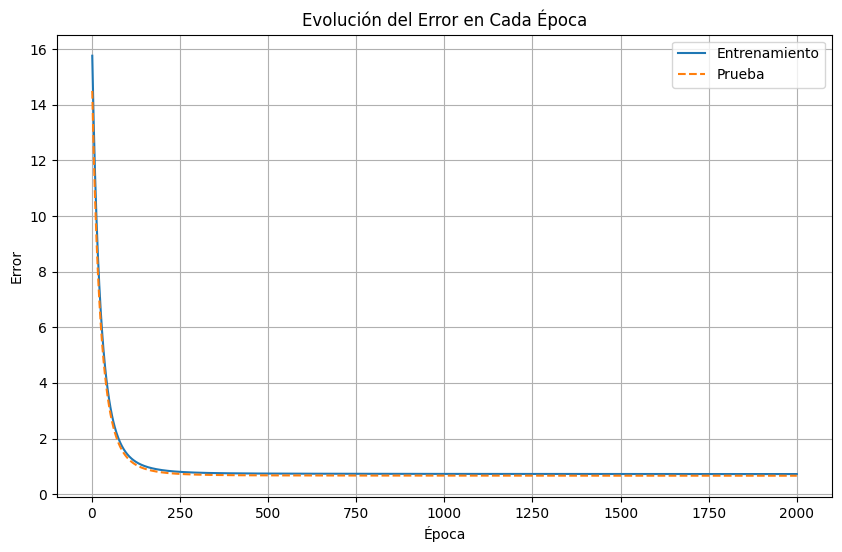

In [ ]:
selected_features = list(correlated_variables(df_cp, 'RainfallTomorrow', 0.04).keys())

df_gradient = df_cp[selected_features + ['RainfallTomorrow']]

columnas_numericas = df_gradient.select_dtypes(include=['float64']).columns.tolist()

scaler = StandardScaler()

df_gradient[columnas_numericas] = scaler.fit_transform(df_cp[columnas_numericas])

X = df_gradient.drop(columns=['RainTomorrow', 'RainfallTomorrow'])
y = df_gradient['RainfallTomorrow']

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learning_rate = 0.01
num_iterations = 2000

theta_inicial = np.random.rand(X_train.shape[1])

theta_optimo, train_errors, test_errors = gradient_descent(X_train, y_train, X_test, y_test, theta_inicial, learning_rate, num_iterations)

epocas = list(range(1, num_iterations + 1))

plt.figure(figsize=(10, 6))
plt.plot(epocas, train_errors, label='Entrenamiento',  linestyle='-')
plt.plot(epocas, test_errors, label='Prueba',  linestyle='--')
plt.title('Evolución del Error en Cada Época')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Realizar predicciones en el conjunto de entrenamiento y prueba
y_train_pred = X_train.dot(theta_optimo)
y_test_pred = X_test.dot(theta_optimo)

# Calcular R2 Score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Calcular MSE
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calcular RMSE
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

# Calcular MAE
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Calcular MAPE
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Imprimir las métricas
print(f'R2 Score en entrenamiento: {r2_train.round(4)}, en prueba: {r2_test.round(4)}')
print(f'MSE en entrenamiento: {mse_train.round(4)}, en prueba: {mse_test.round(4)}')
print(f'RMSE en entrenamiento: {rmse_train.round(4)}, en prueba: {rmse_test.round(4)}')
print(f'MAE en entrenamiento: {mae_train.round(4)}, en prueba: {mae_test.round(4)}')
print(f'MAPE en entrenamiento: {mape_train.round(4)}%, en prueba: {mape_test.round(4)}%')

R2 Score en entrenamiento: 0.2919, en prueba: 0.2766
MSE en entrenamiento: 0.7229, en prueba: 0.6628
RMSE en entrenamiento: 0.8503, en prueba: 0.8141
MAE en entrenamiento: 0.4778, en prueba: 0.4705
MAPE en entrenamiento: 346.7091%, en prueba: 273.9457%
